# Ice Store – Video Game Sales Analysis

## Business Context
Ice is an online video game store operating worldwide. 
The objective of this analysis is to identify patterns that determine whether a game becomes successful, in order to support marketing campaign planning for 2017.

The dataset contains historical sales data up to 2016, including:
- Platforms
- Genres
- Regional sales
- Critic and user scores
- ESRB ratings


## Analytical Objectives

- Prepare and clean the dataset
- Identify sales trends across platforms and years
- Analyze the impact of reviews on sales
- Build regional user profiles (NA, EU, JP)
- Test statistical hypotheses regarding user ratings


## 1. Data Description

- **Name** – Game title  
- **Platform** – Gaming platform  
- **Year_of_Release** – Year the game was released  
- **Genre** – Game genre  
- **NA_sales** – North American sales (in millions of USD)  
- **EU_sales** – European sales (in millions of USD)  
- **JP_sales** – Japanese sales (in millions of USD)  
- **Other_sales** – Sales in other regions (in millions of USD)  
- **Critic_Score** – Critic review score (maximum of 100)  
- **User_Score** – User review score (maximum of 10)  
- **Rating** – ESRB rating  

> **Note:** Data for the year 2016 may be incomplete.


## 2. Data Preparation

In this section, we clean and prepare the dataset for analysis.
This includes standardizing column names, converting data types, handling missing values, and creating additional relevant features.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

games = pd.read_csv('../datasets/games.csv')


### 2.1 Standardizing Column Names

Column names are converted to lowercase to avoid referencing issues during analysis.

In [32]:
games.columns = games.columns.str.lower()


### 2.2 Data Type Conversion

We converted columns to appropriate data types to allow correct numerical analysis.

- **year_of_release**: Converted from `float64` to `Int64`.  
  The column contained missing values, so we used the pandas nullable integer type to preserve them while keeping the year as an integer.

- **user_score**: Converted from `object` to `float64`.  
  The column included non-numeric values (such as "TBD"), so we used `pd.to_numeric()` with `errors='coerce'` to convert valid values and replace invalid ones with `NaN`.


In [33]:
games['year_of_release'] = pd.to_numeric(games['year_of_release'], errors='coerce').astype('Int64')
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

### 2.3 Handling Missing Values

Missing values were identified in the following columns: `name`, `genre`, `year_of_release`, `critic_score`, `user_score`, and `rating`.

Rows with missing values in `name`, `genre`, and `year_of_release` were removed, as these fields are essential for identification and temporal trend analysis.

The value "TBD" in `user_score` was converted to `NaN`, as it indicates that a rating had not yet been determined.

Possible reasons for missing values:

- `name`: Data entry or extraction errors during dataset compilation.
- `genre`: Incomplete metadata or classification issues in the original source.
- `year_of_release`: Missing historical records or incomplete archival data.
- `critic_score`: Some games may not have received professional reviews.
- `user_score`: Games with insufficient user ratings or pending evaluations ("TBD").
- `rating`: ESRB classification may be absent for older titles, games released outside North America, or due to incomplete records.

Missing values in `critic_score`, `user_score`, and `rating` were preserved, since imputing them could introduce bias into correlation analysis, regional comparisons, and hypothesis testing.

This approach maintains analytical integrity while preserving as much valid data as possible.


In [34]:
games = games.dropna(subset=['name'])
games = games.dropna(subset=['genre'])
games = games.dropna(subset=['year_of_release'])


### 2.4 Calculating Total Global Sales

We create a new column representing total global sales by summing regional sales.


In [35]:
games['total_sales'] = (games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales'])

### 2.5 ESRB Rating Standardization

The ESRB rating categories were reviewed for consistency. 

- "K-A" was replaced with "E", as it represents an older classification equivalent to "Everyone".
- "RP" (Rating Pending) was converted to NaN, since it does not represent a finalized rating.

Other ESRB categories (E, E10+, T, M, AO, EC) were preserved as distinct classifications.


In [36]:
games['rating'] = games['rating'].replace('K-A', 'E')
games['rating'] = games['rating'].replace('RP', np.nan)

## 3. Exploratory Data Analysis

In this section, we analyze historical trends in game releases, platform performance, sales distribution, and genre profitability in order to identify patterns that may help forecast 2017 performance.


### 3.1 Number of Games Released Per Year

We analyze how many games were released each year to determine whether all historical periods are equally relevant for forecasting 2017 sales.

The number of games released per year remained relatively low until the mid-1990s, followed by steady growth throughout the 2000s. 

Game releases peaked between 2007 and 2009, after which the number of releases began to decline. 

This trend suggests that the modern video game market structure was established mainly after the early 2000s.

For forecasting 2017 performance, it may be more appropriate to focus on recent years where market conditions resemble the current competitive environment.



<Axes: title={'center': 'Number of Games Released per Year'}, xlabel='Year of Release', ylabel='Number of Games Released'>

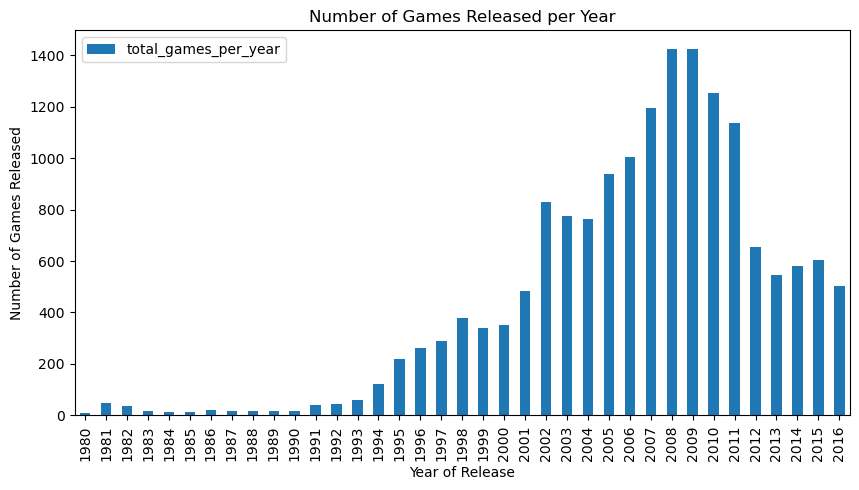

In [37]:
games_per_year = (
    games.groupby('year_of_release')
    .size()
    .reset_index(name='total_games_per_year')
)

games_per_year.plot(
    x='year_of_release',
    y='total_games_per_year',
    kind='bar',
    figsize=(10, 5),
    xlabel='Year of Release',
    ylabel='Number of Games Released',
    title='Number of Games Released per Year'
)


### 3.2 Platform Sales Trends Over Time

We examine how total sales vary across platforms over the years to identify market leaders, declining platforms, and lifecycle patterns.


#### 3.2.1 Identifying Platforms With the Highest Total Sales

We first identify the platforms with the highest total sales to focus on the most commercially significant players in the market.

In [38]:
platform_sales = (
    games.groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
)

platform_sales.head(10)


platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: total_sales, dtype: float64

#### 3.2.2 Annual Sales Distribution

The sales trends clearly demonstrate the lifecycle behavior of gaming platforms.

PS2 shows strong sales in the early 2000s, peaking around 2002–2004, followed by a steady decline as newer generations entered the market.

Wii experienced rapid growth after its launch, reaching peak sales around 2009, but declined sharply afterward.

Xbox 360 and PS3 show similar lifecycle patterns, with peak performance between 2008 and 2011, followed by gradual decline.

Nintendo DS peaked around 2007–2008 and then declined as newer handheld systems emerged.

Overall, the data confirms that gaming platforms typically experience:
- A rapid growth phase after launch
- A peak period lasting a few years
- A gradual decline as new generations replace them

This generational cycle suggests that older platform data may not be representative of the market conditions leading into 2017. Therefore, more recent years should be prioritized when building forecasts.


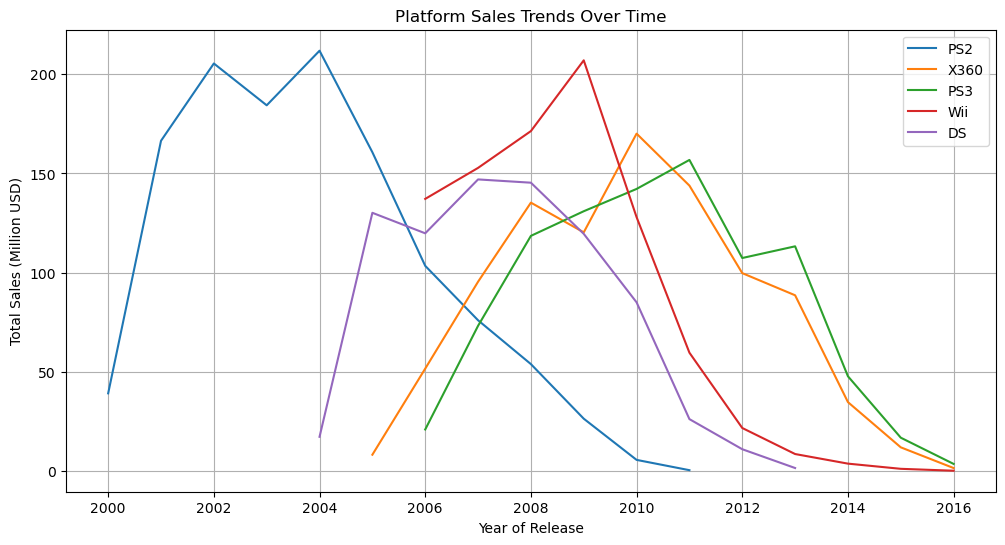

In [39]:
games.loc[15957, 'year_of_release'] = 2007 # (index 15957) was recorded as 1985, the correct release year is 2007

platform_year_sales = (
    games.groupby(['year_of_release', 'platform'])['total_sales']
    .sum()
    .reset_index()
)

top_platforms = platform_sales.head(5).index

plt.figure(figsize=(12, 6))

for platform in top_platforms:
    platform_data = games[games['platform'] == platform]
    
    yearly_sales = (
        platform_data
        .groupby('year_of_release')['total_sales']
        .sum()
    )
    
    plt.plot(yearly_sales.index, yearly_sales.values, label=platform)

plt.title('Platform Sales Trends Over Time')
plt.xlabel('Year of Release')
plt.ylabel('Total Sales (Million USD)')
plt.legend()
plt.grid(True)
plt.show()



#### 3.2.3 Finding platforms that have disappeared

Several platforms show no recent sales activity, indicating that they have exited the market.
This reinforces the importance of focusing only on currently active platforms when forecasting 2017.


In [40]:
platform_last_year = (
    games.groupby('platform')['year_of_release']
    .max()
    .sort_values()
)

platform_last_year.head(10)


platform
2600    1989
GG      1992
SCD     1994
GEN     1994
NES     1994
3DO     1995
TG16    1995
NG      1996
PCFX    1996
SNES    1999
Name: year_of_release, dtype: Int64

#### 3.2.4 Calculating the average lifespan of the platform

### Platform Lifecycle Analysis

The lifecycle analysis shows that most gaming platforms remain commercially active for approximately 5 to 11 years.

Major successful platforms such as PS2, PS3, Xbox 360, PSP, and Wii exhibit lifespans of around a decade, with a clear growth phase, peak period, and gradual decline.

Shorter lifecycles (3–5 years) are typically observed for newer platforms (e.g., PS4, Xbox One, WiiU), reflecting that the dataset only captures their early market years.

Older legacy platforms (e.g., NES, SNES, Game Boy) also show multi-year lifespans but belong to fundamentally different market generations.

PC appears as a special case with a much longer lifespan, as it represents an evolving ecosystem rather than a single hardware generation.

Overall, the results confirm that the gaming industry follows a generational replacement cycle, where new platforms emerge roughly every 5–7 years and gradually replace previous ones.

This reinforces the need to focus on recent years when forecasting 2017 sales, as older platform generations no longer reflect current market dynamics.


In [41]:
platform_lifecycle = (
    games.groupby('platform')['year_of_release']
    .agg(['min', 'max'])
)

platform_lifecycle['lifetime'] = (
    platform_lifecycle['max'] - platform_lifecycle['min']
)

platform_lifecycle.sort_values('lifetime', ascending=False)


,min,max,lifetime
platform,,,
PC,1985,2016,31
GB,1988,2001,13
NES,1983,1994,11
X360,2005,2016,11
PSP,2004,2015,11
PS2,2000,2011,11
DC,1998,2008,10
Wii,2006,2016,10
PS3,2006,2016,10


### 3.3 Selecting the Relevant Time Period

Based on the previous analysis, the video game market clearly follows a generational lifecycle pattern. Most platforms remain commercially active for approximately 5–10 years, experiencing growth, peak performance, and eventual decline.

Data from the 1980s and 1990s represent fundamentally different market conditions and platform generations that are no longer relevant to the competitive environment leading into 2017.

Additionally, sales peaked around 2007–2009, and several major platforms began declining after 2011, reflecting generational transition dynamics.

To build a realistic model for forecasting 2017 performance, it is most appropriate to focus on recent market conditions that resemble the current competitive landscape.

Therefore, the analysis will be restricted to data from 2010 onward. This period captures the active lifecycle of modern platforms while excluding outdated market generations that could distort trend analysis.


### 3.4 Filtering Data for the Selected Period

To ensure that only relevant data is used for forecasting 2017, we create a filtered dataset containing games released from 2010 onward. 

The original dataset is preserved to maintain reproducibility and allow comparisons if needed.


In [42]:
recent_games = games[games['year_of_release'] >= 2010].copy()

### 3.5 Leading and Potentially Profitable Platforms

Based on total global sales in the selected period (2010 onward), the leading platforms are PS3 and Xbox 360, followed by PS4 and 3DS. These platforms dominate cumulative sales within the modern market window.

However, total historical sales alone are not sufficient to forecast 2017 performance. Therefore, we analyzed recent yearly trends to identify growth and decline patterns.

The trend analysis shows that:

- PS3 and Xbox 360 are in clear decline after 2013, indicating the end of their lifecycle.
- Wii and 3DS also show consistent downward trends.
- PS4 demonstrates strong growth between 2014 and 2015 and remains one of the strongest platforms in recent years.
- Xbox One also shows positive growth from 2014 to 2015, suggesting market expansion.
- Although 2016 shows lower sales across platforms, this is likely due to incomplete data.

The year-over-year comparison (2015 vs 2014) confirms this pattern:
- PS4 shows the strongest positive growth.
- Xbox One also demonstrates moderate growth.
- Older-generation platforms (PS3, Xbox 360, 3DS) show significant declines.

Based on both total sales and recent growth trends, PS4 and Xbox One appear to be the most promising platforms for forecasting 2017 performance. These platforms are in active growth or early maturity phases, while previous-generation consoles are clearly in decline.


In [43]:
platform_sales_recent = (
    recent_games.groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
)

platform_sales_recent.head(10)


platform
PS3     587.74
X360    550.41
PS4     314.14
3DS     257.81
Wii     222.97
XOne    159.32
DS      123.75
PC      121.96
WiiU     82.19
PSP      64.05
Name: total_sales, dtype: float64

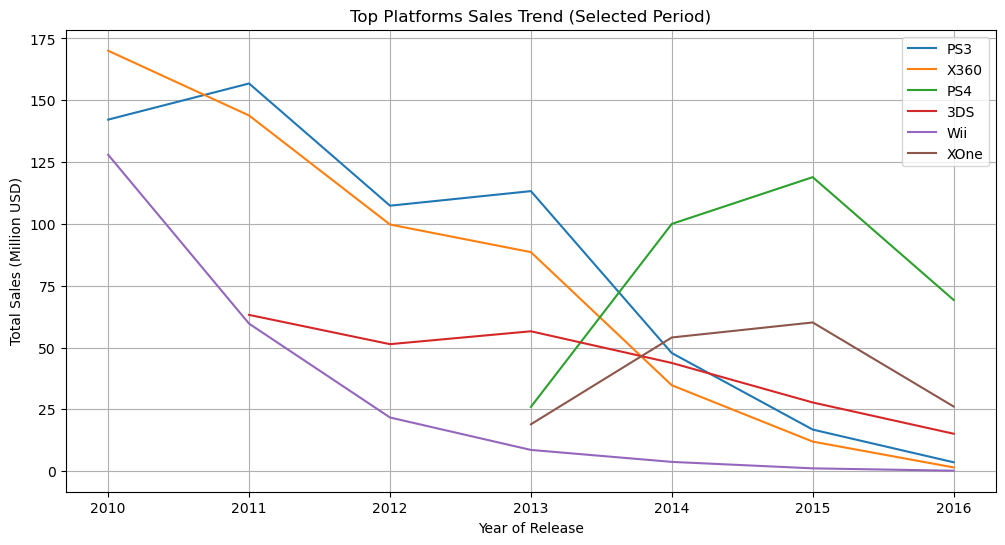

In [44]:
platform_year_recent = (
    recent_games.groupby(['year_of_release', 'platform'])['total_sales']
    .sum()
    .reset_index()
)

top_recent_platforms = platform_sales_recent.head(6).index

plt.figure(figsize=(12, 6))

for platform in top_recent_platforms:
    tmp = platform_year_recent[platform_year_recent['platform'] == platform]
    yearly = tmp.groupby('year_of_release')['total_sales'].sum()
    plt.plot(yearly.index, yearly.values, label=platform)

plt.title('Top Platforms Sales Trend (Selected Period)')
plt.xlabel('Year of Release')
plt.ylabel('Total Sales (Million USD)')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
recent_trend = (
    recent_games[recent_games['year_of_release'].isin([2014, 2015])]
    .groupby(['platform', 'year_of_release'])['total_sales']
    .sum()
    .unstack()
)

recent_trend['change_2015_vs_2014'] = recent_trend[2015] - recent_trend[2014]
recent_trend.sort_values('change_2015_vs_2014', ascending=False).head(10)


year_of_release,2014,2015,change_2015_vs_2014
platform,,,
PS4,100.00,118.90,18.90
XOne,54.07,60.14,6.07
PSP,0.24,0.12,-0.12
Wii,3.75,1.14,-2.61
PC,13.28,8.52,-4.76
PSV,11.90,6.25,-5.65
WiiU,22.03,16.35,-5.68
3DS,43.76,27.78,-15.98
X360,34.74,11.96,-22.78


### 3.6 Global Sales Distribution by Platform

The boxplot analysis shows that sales distributions across all platforms are highly right-skewed.

For every platform, the majority of games generate relatively low sales, as indicated by the low median values and the concentration of data near zero. At the same time, a small number of titles achieve exceptionally high sales, appearing as extreme outliers.

Platforms such as PS3 and Xbox 360 exhibit the highest maximum values, reflecting the presence of major blockbuster titles during their peak years. PS4 and Xbox One show comparable median performance, indicating competitive average sales per title in the recent market period.

Although differences in median sales exist between platforms, they are not dramatically large. The primary driver of total platform revenue appears to be a limited number of highly successful games rather than consistently high performance across all releases.

Overall, sales variability within each platform is substantial, and market success depends heavily on breakout titles.


<Figure size 1200x600 with 0 Axes>

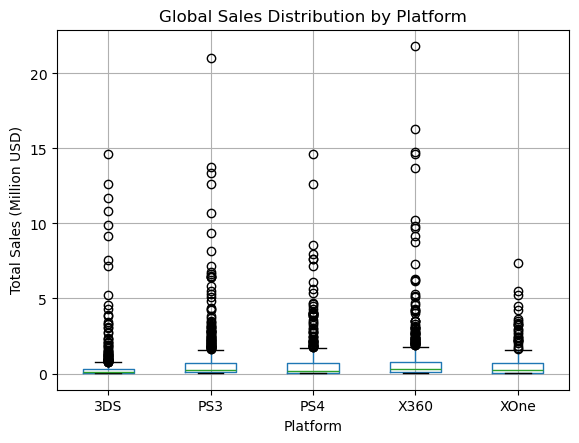

In [46]:
top_platforms_recent = ['PS4', 'XOne', 'PS3', 'X360', '3DS']

plt.figure(figsize=(12, 6))

recent_games[recent_games['platform'].isin(top_platforms_recent)] \
    .boxplot(column='total_sales', by='platform')

plt.title('Global Sales Distribution by Platform')
plt.suptitle('')
plt.xlabel('Platform')
plt.ylabel('Total Sales (Million USD)')
plt.show()


### 3.7 Impact of Reviews on Sales (PS4 Case Study)

To evaluate whether review scores influence sales performance, we analyzed the relationship between critic scores, user scores, and total global sales for PS4 titles.

The scatter plot of critic scores versus sales suggests a positive relationship. The calculated correlation coefficient (≈ 0.41) indicates a moderate positive correlation between critic ratings and global sales. This suggests that higher critic scores are generally associated with stronger commercial performance.

In contrast, the relationship between user scores and sales appears negligible. The calculated correlation coefficient (≈ -0.03) indicates no meaningful linear relationship between user ratings and total sales.

These results suggest that professional critic reviews may have a greater influence on purchasing decisions than user ratings, at least for PS4 titles during the selected period.

However, while critic scores show a moderate association with sales, they are not the sole determinant of success. The wide dispersion of points indicates that other factors—such as marketing, franchise popularity, and brand strength—likely play significant roles in driving commercial performance.


In [47]:
ps4_data = recent_games[recent_games['platform'] == 'PS4']


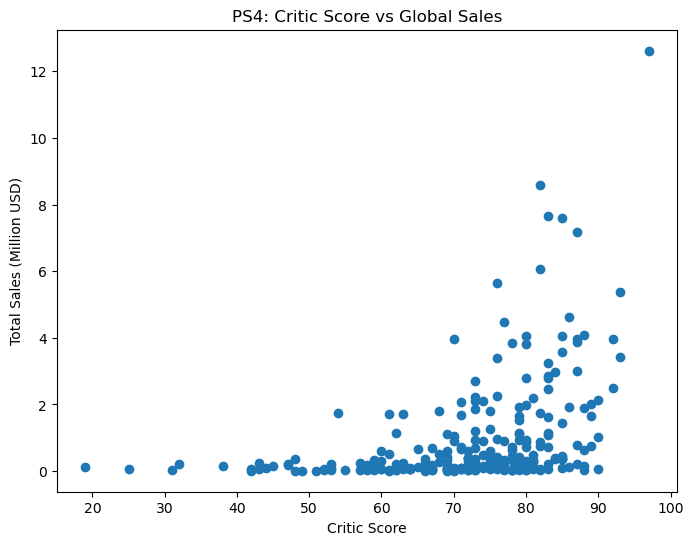

In [48]:
plt.figure(figsize=(8, 6))

plt.scatter(ps4_data['critic_score'], ps4_data['total_sales'])
plt.xlabel('Critic Score')
plt.ylabel('Total Sales (Million USD)')
plt.title('PS4: Critic Score vs Global Sales')
plt.show()


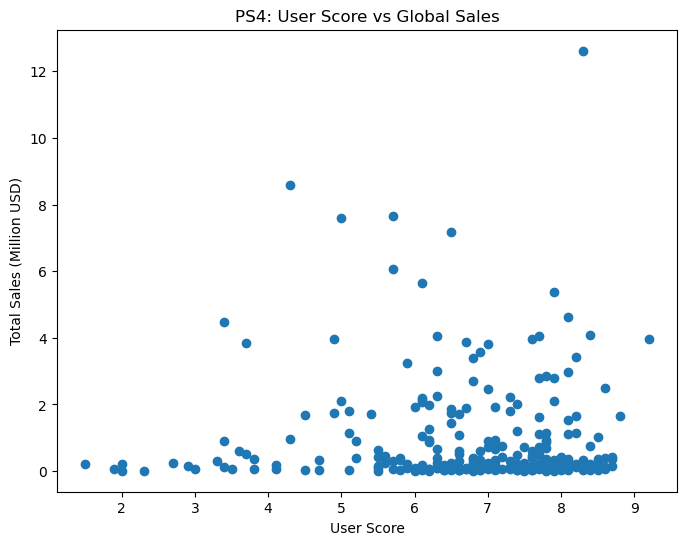

In [49]:
plt.figure(figsize=(8, 6))

plt.scatter(ps4_data['user_score'], ps4_data['total_sales'])
plt.xlabel('User Score')
plt.ylabel('Total Sales (Million USD)')
plt.title('PS4: User Score vs Global Sales')
plt.show()


In [50]:
critic_corr = ps4_data[['critic_score', 'total_sales']].corr().iloc[0,1]
user_corr = ps4_data[['user_score', 'total_sales']].corr().iloc[0,1]

critic_corr, user_corr


(np.float64(0.40656790206178123), np.float64(-0.03195711020455685))

### 3.8 Cross-Platform Sales Comparison

To assess whether platform choice influences commercial performance, we analyzed games released on multiple platforms during the selected period and compared their average global sales.

The results show clear variation in average sales across platforms. PS4 leads with the highest average sales per title, followed by Xbox 360 and PS3. Xbox One also demonstrates competitive performance, though slightly below older peak-generation platforms.

In contrast, handheld platforms such as 3DS, DS, and PSV show substantially lower average sales per title. Similarly, older platforms like PS2 and PSP exhibit reduced commercial performance.

These findings suggest that platform ecosystem strength and generational relevance significantly impact sales outcomes. Even when the same game is released across multiple platforms, performance is not uniform.

Overall, newer-generation consoles—particularly PS4 and Xbox One—appear to provide stronger commercial potential, reinforcing earlier conclusions about focusing on active and growing platforms when forecasting 2017 performance.


In [51]:
multi_platform_games = (
    recent_games.groupby('name')['platform']
    .nunique()
)

multi_platform_games = multi_platform_games[multi_platform_games > 1].index

multi_games_data = recent_games[
    recent_games['name'].isin(multi_platform_games)
]

multi_sales = (
    multi_games_data.groupby('platform')['total_sales']
    .mean()
    .sort_values(ascending=False)
)

multi_sales


platform
PS4     0.880943
X360    0.802706
PS3     0.735842
XOne    0.603080
Wii     0.524153
3DS     0.318828
WiiU    0.302424
DS      0.278102
PC      0.267305
PS2     0.207778
PSP     0.187411
PSV     0.147165
Name: total_sales, dtype: float64

### 3.9 Genre Distribution and Profitability

We analyzed total and average global sales by genre to evaluate overall market performance during the selected period.

In terms of total sales, Action clearly dominates the market, followed by Shooter and Sports. Role-Playing also represents a strong segment in cumulative revenue. This indicates that action-oriented and competitive genres capture a large share of total industry revenue.

However, total sales alone can be influenced by the number of releases within each genre. Therefore, we also examined average sales per title.

When analyzing mean sales per game, Shooter ranks first by a significant margin, followed by Platform and Sports. This suggests that Shooter titles tend to generate stronger revenue per release, likely due to franchise strength and broad consumer appeal.

In contrast, genres such as Puzzle, Adventure, and Strategy show the lowest average sales per title, indicating more niche audiences or lower blockbuster potential.

Overall, while Action leads in total revenue, Shooter appears to be the most commercially efficient genre on a per-title basis. These findings suggest that high-performing genres are typically associated with competitive gameplay, strong franchises, and mass-market appeal, making them more attractive for forecasting future success.


In [52]:
genre_sales = (
    recent_games.groupby('genre')['total_sales']
    .sum()
    .sort_values(ascending=False)
)

genre_sales


genre
Action          673.09
Shooter         479.74
Sports          328.39
Role-Playing    315.28
Misc            234.56
Racing          122.68
Platform        119.72
Fighting         81.59
Simulation       71.75
Adventure        61.00
Strategy         35.84
Puzzle           20.60
Name: total_sales, dtype: float64

In [53]:
genre_mean_sales = (
    recent_games.groupby('genre')['total_sales']
    .mean()
    .sort_values(ascending=False)
)

genre_mean_sales


genre
Shooter         1.170098
Platform        0.782484
Sports          0.571113
Role-Playing    0.555070
Racing          0.517637
Action          0.450227
Fighting        0.410000
Misc            0.407222
Simulation      0.330645
Strategy        0.210824
Puzzle          0.180702
Adventure       0.108348
Name: total_sales, dtype: float64

## 4. Regional User Profiles


### 4.1 Top Platforms by Region

The regional comparison reveals clear structural differences in platform preferences.

In North America, Xbox 360 leads by a significant margin, followed by PS3 and Wii. Xbox One and PS4 also show strong performance, confirming North America as a console-dominated market with strong Microsoft presence.

In Europe, PS3 ranks first, followed by Xbox 360 and PS4. PlayStation platforms appear slightly stronger overall compared to North America, indicating a stronger Sony market position in the region.

Japan presents a markedly different profile. The 3DS clearly dominates the market, with significantly higher sales than home consoles. PSP and PSV also perform relatively well, reinforcing Japan’s preference for portable gaming systems. Xbox platforms show minimal presence in this region.

Overall, Western markets (North America and Europe) are dominated by home consoles, particularly PlayStation and Xbox systems, while Japan demonstrates a strong preference for handheld platforms.

These regional differences highlight the importance of localized platform strategies when forecasting 2017 performance.


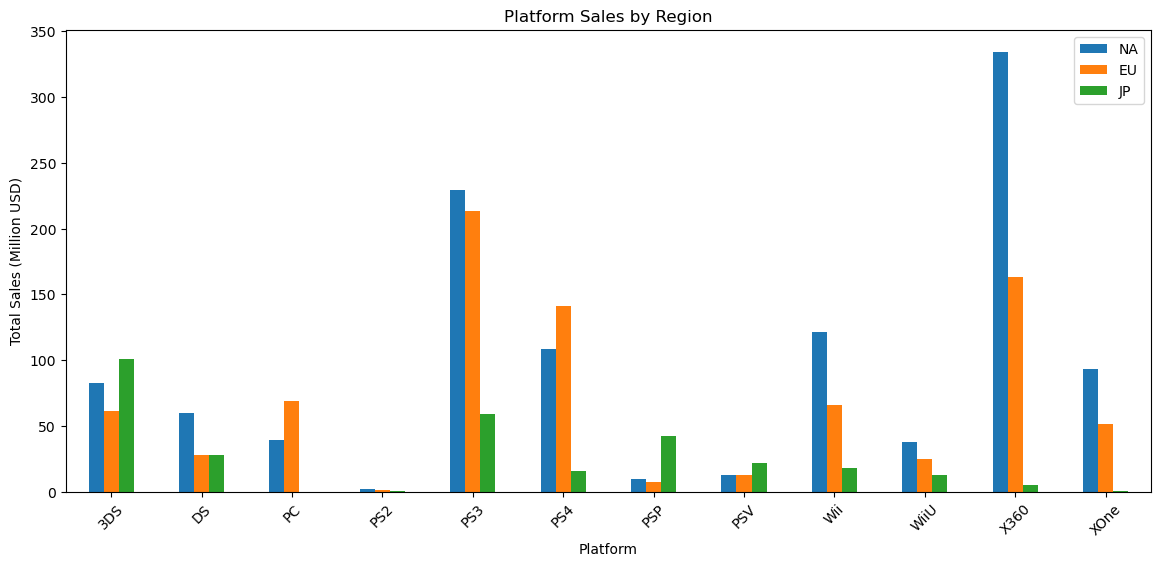

In [57]:
na_platform = (
    recent_games.groupby('platform')['na_sales']
    .sum()
    .sort_values(ascending=False)
)

eu_platform = (
    recent_games.groupby('platform')['eu_sales']
    .sum()
    .sort_values(ascending=False)
)

jp_platform = (
    recent_games.groupby('platform')['jp_sales']
    .sum()
    .sort_values(ascending=False)
)

regional_platforms = pd.DataFrame({
    'NA': na_platform,
    'EU': eu_platform,
    'JP': jp_platform
}).fillna(0)

regional_platforms.plot(
    kind='bar',
    figsize=(14,6)
)

plt.title('Platform Sales by Region')
plt.ylabel('Total Sales (Million USD)')
plt.xlabel('Platform')
plt.xticks(rotation=45)
plt.show()


### 4.2 Top Genres by Region

The regional genre distribution reveals both similarities and significant cultural differences across markets.

In North America, Action clearly dominates, followed by Shooter and Sports. These genres reflect strong demand for competitive, fast-paced, and franchise-driven titles.

Europe shows a very similar pattern, with Action and Shooter leading sales. However, the gap between genres is slightly narrower compared to North America, indicating a somewhat more balanced genre distribution.

Japan presents a distinctly different profile. While Action remains relevant, Role-Playing games perform exceptionally well, nearly matching or surpassing Western-dominated genres. In contrast, Shooter games generate substantially lower sales in Japan compared to North America and Europe.

Sports and Shooter genres, which are major revenue drivers in Western markets, are significantly less dominant in Japan. This suggests strong regional cultural preferences, particularly Japan’s long-standing affinity for RPG titles.

Overall, Western markets are heavily driven by Action, Shooter, and Sports genres, while Japan demonstrates stronger demand for Role-Playing games. These differences highlight the importance of tailoring genre-based marketing strategies to regional preferences when forecasting 2017 performance.


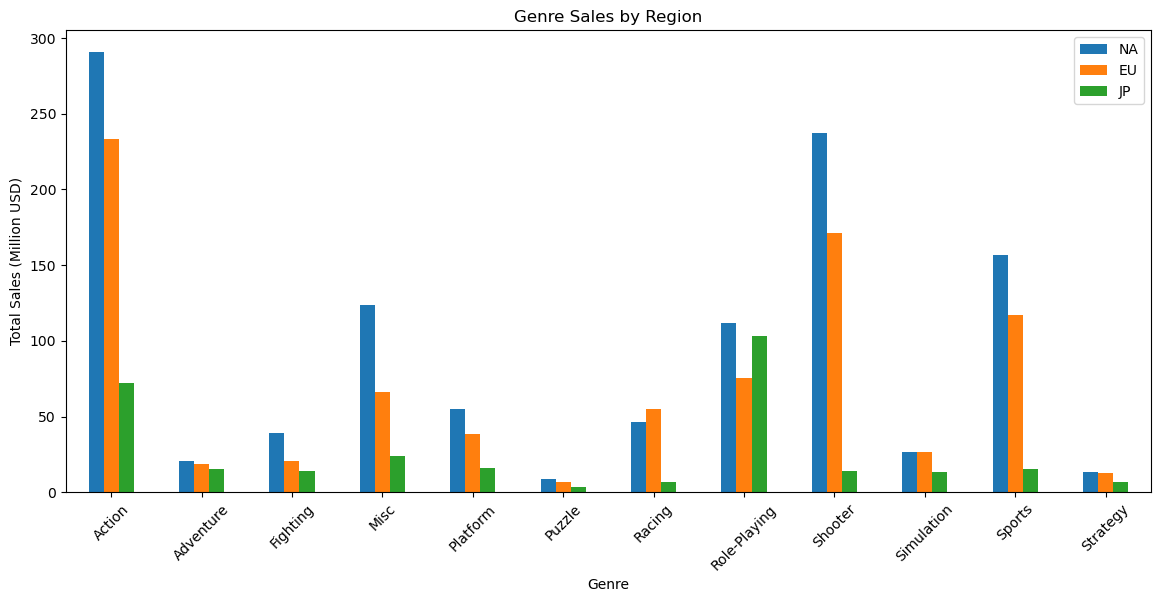

In [59]:
na_genre = (
    recent_games.groupby('genre')['na_sales']
    .sum()
    .sort_values(ascending=False)
)

eu_genre = (
    recent_games.groupby('genre')['eu_sales']
    .sum()
    .sort_values(ascending=False)
)

jp_genre = (
    recent_games.groupby('genre')['jp_sales']
    .sum()
    .sort_values(ascending=False)
)

regional_genres = pd.DataFrame({
    'NA': na_genre,
    'EU': eu_genre,
    'JP': jp_genre
}).fillna(0)

regional_genres.plot(
    kind='bar',
    figsize=(14,6)
)

plt.title('Genre Sales by Region')
plt.ylabel('Total Sales (Million USD)')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.show()


### 4.3 ESRB Rating Impact by Region

The regional analysis of ESRB ratings reveals meaningful differences in content preferences.

In North America and Europe, games rated "M" (Mature) generate the highest total sales, indicating strong demand for adult-oriented and action-heavy content. Titles rated "E" (Everyone) also perform strongly, reflecting broad market appeal across age groups.

In contrast, Japan shows a more balanced distribution across rating categories, with no single rating dominating to the same extent observed in Western markets. Overall sales volumes for ESRB-rated games are also lower in Japan, suggesting that ESRB classification may have less direct commercial impact in that region.

These results suggest that ESRB ratings play a more significant role in Western markets, where mature-rated titles contribute substantially to total revenue. In Japan, purchasing behavior appears to be influenced more by genre and platform preferences rather than rating classification alone.

Therefore, when forecasting 2017 performance, content classification should be considered more strategically in North America and Europe than in Japan.


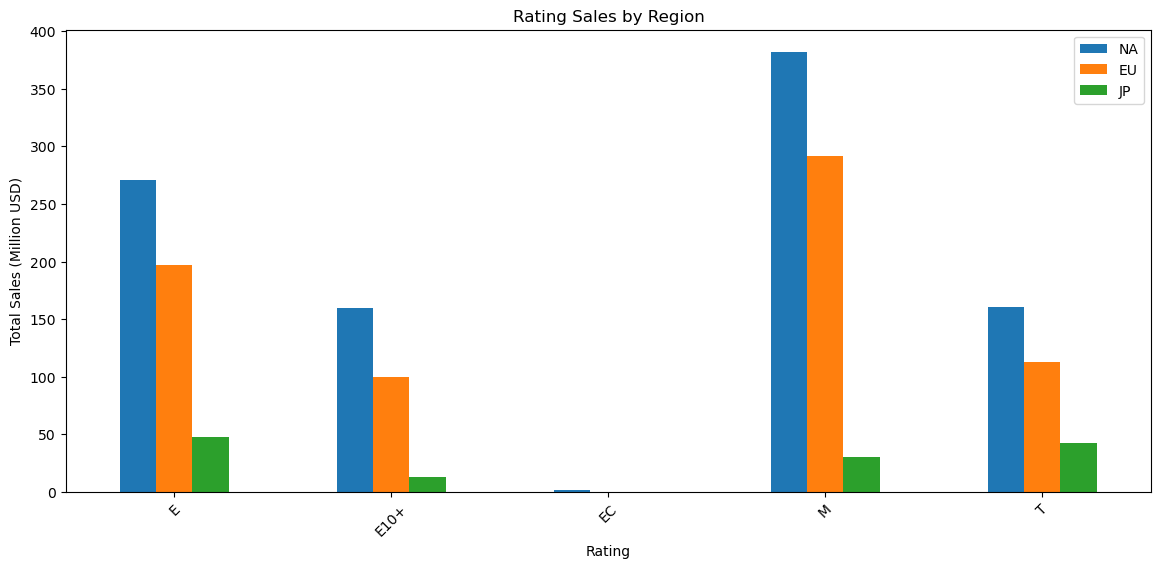

In [61]:
na_rating = (
    recent_games.groupby('rating')['na_sales']
    .sum()
    .sort_values(ascending=False)
)

eu_rating = (
    recent_games.groupby('rating')['eu_sales']
    .sum()
    .sort_values(ascending=False)
)

jp_rating = (
    recent_games.groupby('rating')['jp_sales']
    .sum()
    .sort_values(ascending=False)
)

regional_ratings = pd.DataFrame({
    'NA': na_rating,
    'EU': eu_rating,
    'JP': jp_rating
}).fillna(0)

regional_ratings.plot(
    kind='bar',
    figsize=(14,6)
)

plt.title('Rating Sales by Region')
plt.ylabel('Total Sales (Million USD)')
plt.xlabel('Rating')
plt.xticks(rotation=45)
plt.show()
